TP: Définition d'un réseau convolutionnel
=============

Introduction au sujet
-----

L'objectif de ce sujet de créer un réseau convolutionnel pour la base MNIST. 

**Afin d'avoir un code optimisé, vous éviterez d'utiliser les instructions python3 if, for et while (sauf mention contraire dans les sujets).**

Le code est à écrire en python3 à la suite des questions dans ce fichier. Vous appuierez soit sur le bouton *run cell*, soit sur les touches *Ctrl-Entrée*, à l’intérieur de la zone de saisie, pour lancer l'exécution de vos commandes. Si la commande est en cours d’exécution une étoile apparaît à côté de la zone de saisie de la commande : In [\*]. Une fois le calcul achevé, l'étoile est remplacée par le numéro du run permettant de retrouver par la suite dans quel ordre ont été lancés chaque bloc.

Commencez par importer les librairies nécessaires au TP. Les dernières lignes sont spécifiques à l'usage d'un notebook. Elles permettent d'indiquer que les affichages matplotlib doivent être faits dans le notebook et non dans une fenêtre extérieure. 

N'hésitez pas à regarder régulièrement la documentation de ces librairies, des exemples d'utilisation accompagnent généralement l'explication de chaque fonction.

Langage utilisé:
- Python 3: https://docs.python.org/3/

Librairie de math:
- Numpy: https://docs.scipy.org/doc/numpy/reference/

Librairie d'affichage de données:
- Matplotilb: https://matplotlib.org/contents.html

Librairie de Deep Learning
- PyTorch: https://pytorch.org/docs/stable/index.html


In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

Chargement et visulation des données
-----

Commencez par récupérer les données de la base MNIST (train et test), vous pouvez utiliser la classe [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) de `torchvision` pour cela. Vous stockerez les datasets dans les variables `mnist_train` et `mnist_test`.

Vous appliquerez une transformation permettant d'avoir des objets de type `Tensor` lors de l'utilisation des datasets.

In [2]:
mnist_train = torchvision.datasets.MNIST('.',train=True ,download=True,transform=transforms.ToTensor())
mnist_test  = torchvision.datasets.MNIST('.',train=False,download=True,transform=transforms.ToTensor())

Un [dataset](https://pytorch.org/vision/stable/datasets.html) peut s'utiliser comme un tableau python. Affichez la $10^\text{ème}$ image d'apprentissage sous la forme d'une matrice $28 \times 28$ avec `matplotlib` et préciser le label attendu pour cet exemple.

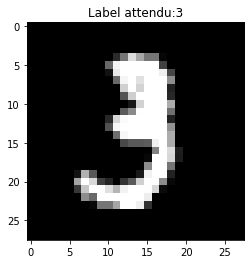

In [3]:
im10,y10 = mnist_train[10]
im10 = im10.squeeze()
plt.imshow(im10,cmap='gray')
plt.title('Label attendu:'+str(y10))
plt.show()

Nous allons utiliser des objets [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) pour gérer le découpage en batch de la base. Déclarez les variables `data_train` et `data_test`. Nous prendrons des batchs de taille 10 avec un tirage aléatoire pour `train` (et pas de tirage pour `test`).

In [4]:
data_train = DataLoader(mnist_train, batch_size=10, shuffle=True)
data_test  = DataLoader(mnist_test , batch_size=10, shuffle=False)

Affichez dans une figure de taille $20 \times 20$ sur 10 lignes et 10 colonnes, les 100 premières images. Vous mettrez au-dessus de chaque image son label. Vous utiliserez l'objet `data_train` pour cette question.

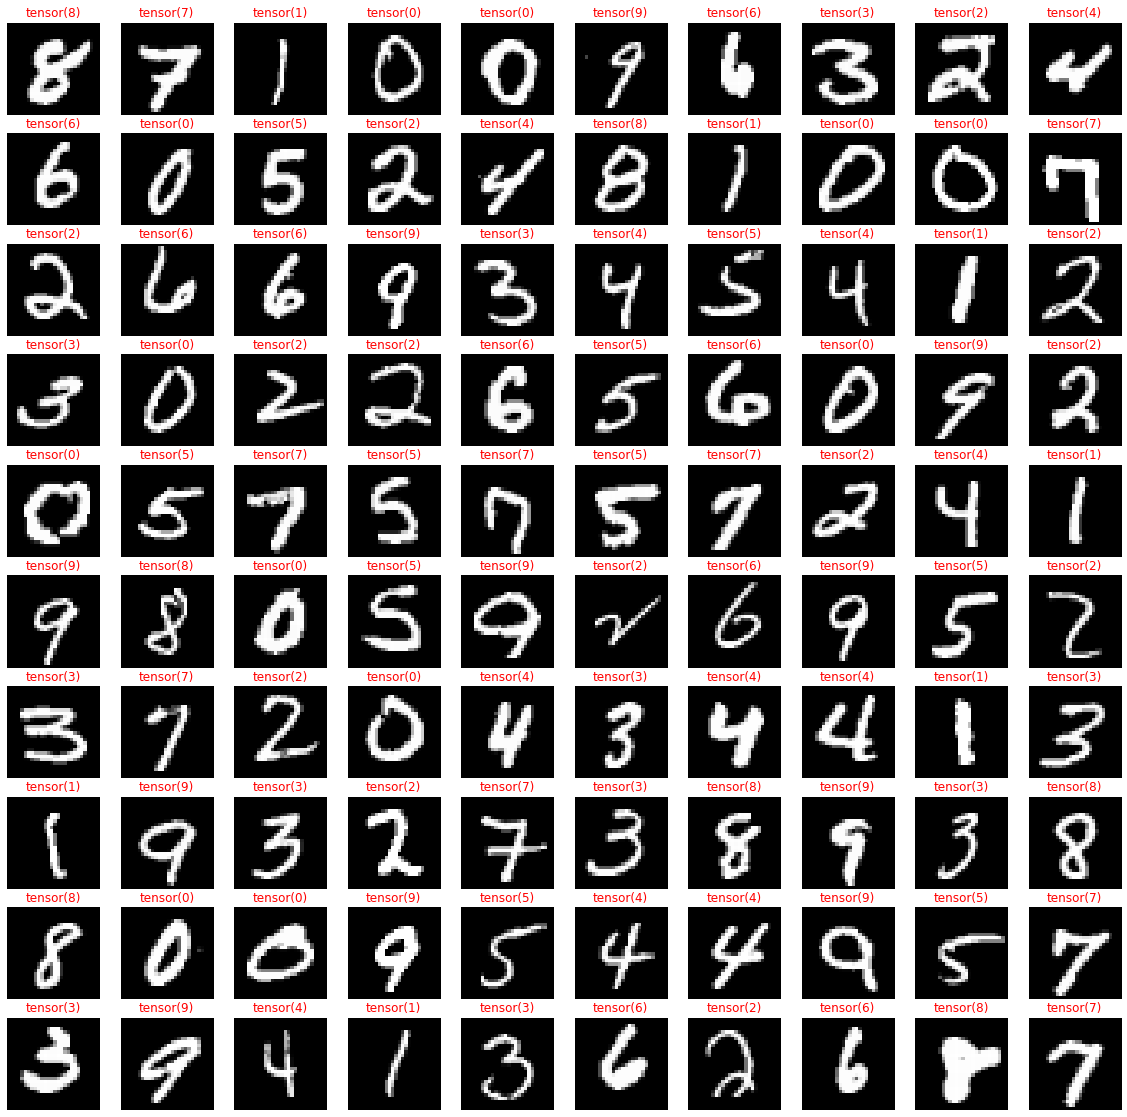

In [5]:
_,ax = plt.subplots(10, 10, figsize=(20,20))
iter_data = iter(data_train)
for i in range(10):
    im,y = next(iter_data)
    for j in range(10):
        ax[i,j].imshow(im[j].squeeze(),cmap='gray')
        ax[i,j].axis('off')
        ax[i, j].set_title(y[j],color='red')
plt.show()

Réseau entièrement connecté
----

Nous allons dans cette partie, définir un réseau entièrement connecté.

Définissez un réseau entièrement connecté avec 128 neurones dans la couche cachée avec [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) et [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). Vous appellerez ce classifier *mnist_classifier_FC*. On considéra que l'entrée du réseau sera un vecteur de taille $784=28\times 28$.

La structure du réseau sera la suivante:
- une couche de 784 vers 128,
- une fonction d'activation de type ReLU, 
- une couche de sortie.

In [6]:
mnist_classifier_FC =  nn.Sequential(
    nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128,10),
    )
print(mnist_classifier_FC)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)


Définissez une fonction de coût de type [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [7]:
loss = nn.CrossEntropyLoss()

Définissez un `optimiser` de type [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) avec un taux d'apprentissage de 0.1 .

In [8]:
optimizer = torch.optim.SGD(mnist_classifier_FC.parameters(), lr=1e-1)

Apprenez le classifier *mnist_classifier_FC* sur 2 époques. Vous redimensionnerez les images en vecteur de taille 784 avant de les passer dans le réseau avec la méthode `view`.

In [9]:
%%time
ll =[]
for i in range(2):
    for x,y in data_train: 
        y_pred = mnist_classifier_FC(x.view(-1,28*28))
        #print(y_pred)
        l = loss(y_pred, y)
        ll+=l.item(),
        l.backward() # calcul des gradients
        optimizer.step()
        optimizer.zero_grad()

CPU times: user 5.11 s, sys: 1.07 s, total: 6.18 s
Wall time: 5.42 s


Parcourez la base de test et compter le nombre d'erreur du réseau que vous venez d'apprendre. Attention la sortie du réseau n'est pas un numéro de classe.

In [10]:
score = 0
mnist_classifier_FC.eval()
with torch.no_grad():
    for x,y in data_test:
        y_pred = torch.argmax(mnist_classifier_FC(x.view(-1,28*28)),-1)
        #print(y_pred)
        score += torch.sum(y_pred!=y)
    print('Taux de mal classé:',str(score.item()/len(mnist_test)*100)+'%')

Taux de mal classé: 3.58%


Visualisez les données bien et mal classées. Vous afficherez un tableau de $10 \times 10$ les 5 premières colonnes correspondront aux premières données bien classées et les 5 suivantes aux données mal classées. Vous afficherez également en titre les labels attendus et les labels trouvés.

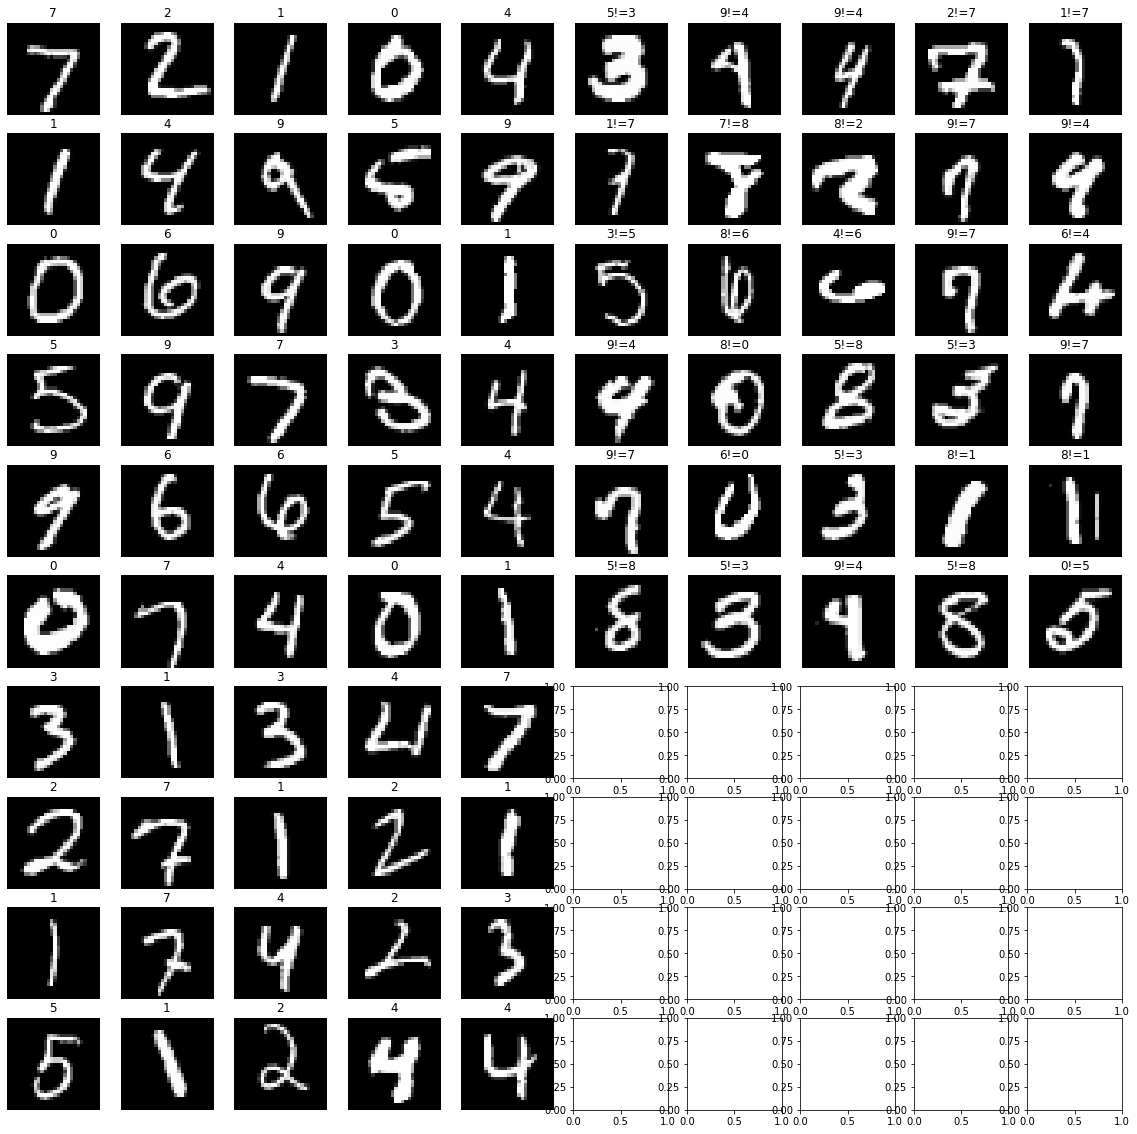

In [11]:
mnist_classifier_FC.eval()

_,ax = plt.subplots(10, 10, figsize=(20,20))
i_ok = 0
i_ko = 0 
with torch.no_grad():
    for x,y in data_test:
        y_pred = torch.argmax(mnist_classifier_FC(x.view(-1,28*28)),-1)
        for i in range(len(y)):
            if y_pred[i]==y[i] and i_ok<50:
                ax[i_ok//5,i_ok%5].imshow(x[i].squeeze(),cmap='gray')
                ax[i_ok//5,i_ok%5].axis('off')
                ax[i_ok//5,i_ok%5].set_title(y_pred[i].item())
                i_ok += 1
            elif y_pred[i]!=y[i] and i_ko<50:
                ax[i_ko//5,5+i_ko%5].imshow(x[i].squeeze(),cmap='gray')
                ax[i_ko//5,5+i_ko%5].axis('off')
                ax[i_ko//5,5+i_ko%5].set_title(str(y_pred[i].item())+'!='+str(y[i].item()))
                i_ko += 1
            else:
                break

plt.show()

Redéfinition d'un réseau entièrement connecté à l'aide d'une classe
----

Nous allons dans cette partie redéfinir le réseau précédent à l'aide d'une classe héritant de [torch.nn.Module]().

Définissez une classe `FC_model` héritant de `torch.nn.Module` permettant de définir l'architecture du réseau précédent.

In [12]:
class FC_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
mnist_classifier_FC2 = FC_model()
print(mnist_classifier_FC2)

FC_model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Lancez l'apprentissage du réseau sur les données d'apprentissage. On redéfinira la fonction de coût et l'optimiser comme précédemment et on fera le même nombre d'époque.

In [13]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_classifier_FC2.parameters(), lr=1e-1)
for i in range(2):
    for x,y in data_train: 
        y_pred = mnist_classifier_FC2(x.view(-1,28*28))

        l = loss(y_pred, y)
        ll+=l.item(),
        l.backward() # calcul des gradients
        optimizer.step()
        optimizer.zero_grad()

CPU times: user 5.1 s, sys: 1.26 s, total: 6.36 s
Wall time: 5.49 s


Lancez l'évaluation du réseau sur les données de test. 

In [14]:
score = 0
mnist_classifier_FC2.eval()
with torch.no_grad():
    for x,y in data_test:
        y_pred = torch.argmax(mnist_classifier_FC2(x.view(-1,28*28)),-1)
        #print(y_pred)
        score += torch.sum(y_pred!=y)
    print('Taux de mal classé:',str(score.item()/len(mnist_test)*100)+'%')

Taux de mal classé: 2.64%


Réseau convolutionnel
-----

Définissez une nouvelle architecture basée sur un réseau convolutionel ayant la structure suivante:

in -> conv 1 -> pool 1 -> conv 2 -> pool 2 -> reshape -> FC -> dropout -> out

* conv 1 : 32 filtres, un noyau de taille $5 \times 5$ et une activation de type relu.
* pool 1 : maxpooling avec une fenêtre de taille $2 \times 2$ et un décalage de 2
* conv 2 : 64 filtres, un noyau de taille $5 \times 5$ et une activation de type relu.
* pool 2 : maxpooling avec une fenêtre de taille $2 \times 2$ et un décalage de 2 
* dropout de 0.4
* FC     : 1024 sorties, activation de type relu.
* une couche de sortie


In [15]:
class CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(nn.Conv2d(1,32,5),nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = torch.nn.Sequential(nn.Conv2d(32,64,5),nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1   = torch.nn.Sequential(nn.Linear(1024,1024),nn.ReLU())
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1024,10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.pool2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
cnn = CNN_model()
print(cnn)

CNN_model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


Lancez l'apprentissage du réseau convolutionnel sur les données d'apprentissage. On utilisera un optimiseur de type [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html?highlight=adam#torch.optim.AdamW) avec un learning rate de 1e-2 sur 2 époques (il faudrait plus d'époque pour converger, mais cela nécessiterait plus de temps de calcul).

In [16]:
%%time
cnn = CNN_model()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3)
ll=[]
for i in range(2):
    for x,y in data_train: 
        y_pred = cnn(x)

        l = loss(y_pred, y)
        ll +=l.item(),
        l.backward() # calcul des gradients
        optimizer.step()
        optimizer.zero_grad()

CPU times: user 2min, sys: 1min 22s, total: 3min 23s
Wall time: 1min 20s


Lancez l'évaluation du réseau sur les données de test. N'oubliez pas de passer le réseau en mode `eval` pour désactiver le *dropout*. Ce réseau est-il meilleur que le réseau entièrement connecté précédent.

In [18]:
score = 0
cnn.eval()
with torch.no_grad():
    for x,y in data_test:
        y_pred = torch.argmax(cnn(x),-1)
        #print(y_pred)
        score += torch.sum(y_pred!=y)
    print('Taux de mal classé:',str(score.item()/len(mnist_test)*100)+'%')

Taux de mal classé: 0.9299999999999999%


Visualisez les données bien et mal classées comme précédemment.

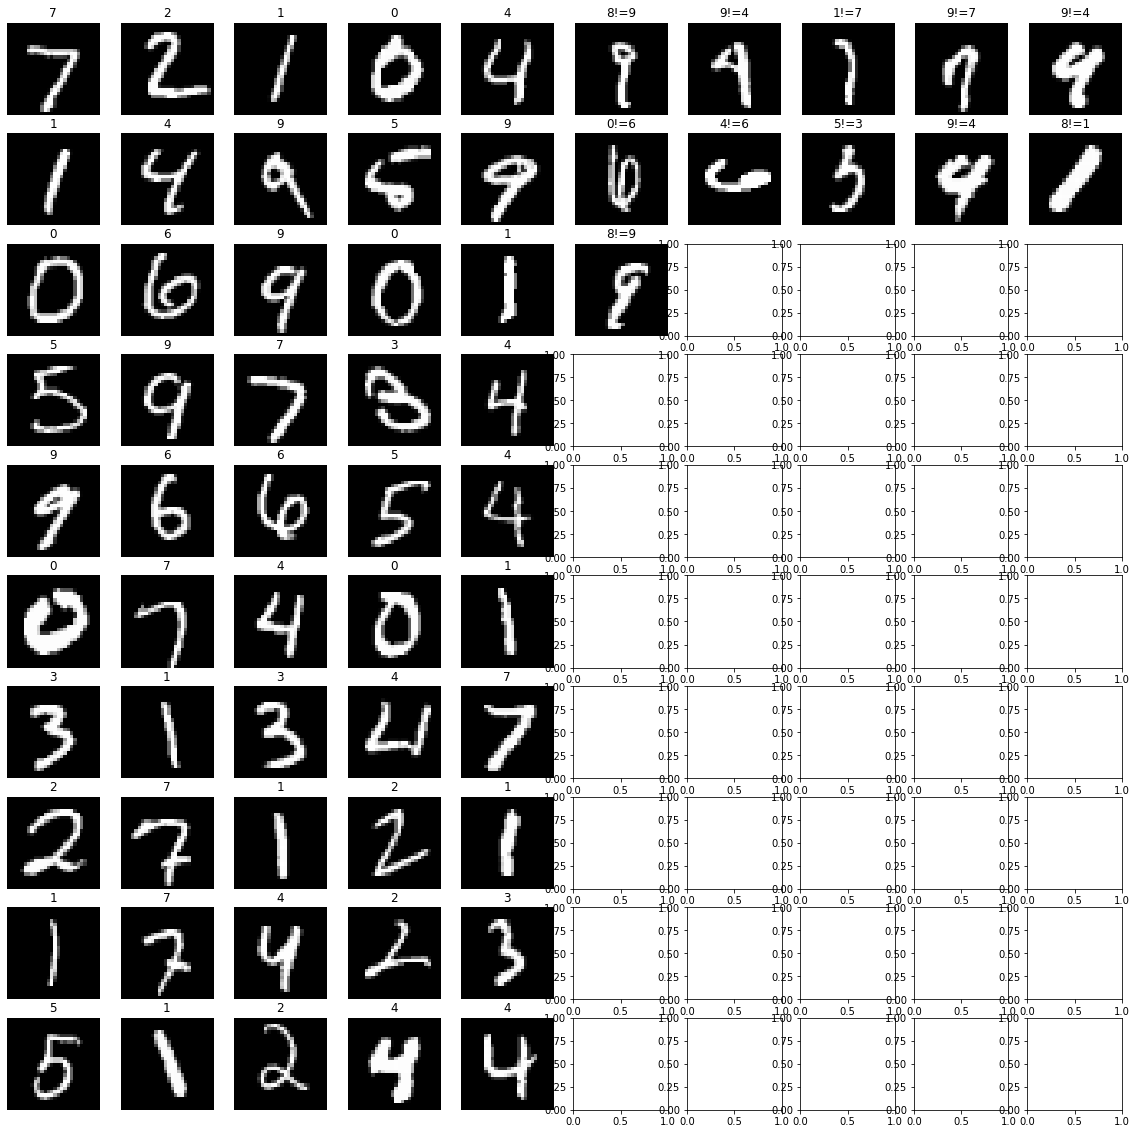

In [19]:
cnn.eval()

_,ax = plt.subplots(10, 10, figsize=(20,20))
i_ok = 0
i_ko = 0 
with torch.no_grad():
    for x,y in data_test:
        y_pred = torch.argmax(cnn(x),-1)
        for i in range(len(y)):
            if y_pred[i]==y[i] and i_ok<50:
                ax[i_ok//5,i_ok%5].imshow(x[i].squeeze(),cmap='gray')
                ax[i_ok//5,i_ok%5].axis('off')
                ax[i_ok//5,i_ok%5].set_title(y_pred[i].item())
                i_ok += 1
            elif y_pred[i]!=y[i] and i_ko<50:
                ax[i_ko//5,5+i_ko%5].imshow(x[i].squeeze(),cmap='gray')
                ax[i_ko//5,5+i_ko%5].axis('off')
                ax[i_ko//5,5+i_ko%5].set_title(str(y_pred[i].item())+'!='+str(y[i].item()))
                i_ko += 1
            else:
                break

plt.show()